In [1]:
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### AVG. STD ERROR CALCULATION

In [6]:
def parse_input_and_compute_avg_stderr(input_data):
    # Split the input data into lines
    lines = input_data.strip().split('\n')

    # Initialize a list to store extracted standard errors
    std_errors = []

    # Iterate over lines starting from the second line (skipping the header)
    for line in lines[1:]:
        # Split each line by '|' to extract fields
        fields = line.split('|')
        fields = list(filter(lambda x: x != '', fields))
        # Extract the standard error value (last element) and convert it to float
        # We use strip() to remove any leading/trailing whitespace and '±' characters
        stderr_value = float(fields[-1].strip().replace('±', '').strip())
        # Append the extracted standard error to the list
        std_errors.append(stderr_value)

    # Calculate the average standard error
    average_stderr = sum(std_errors) / len(std_errors) if std_errors else 0

    # Return the average standard error
    return average_stderr

Average Std Error: 0.0338


In [29]:
# Input data (you can replace this with any input in the specified format)
input_data = """
|-----------|-------|------|-----:|------|-----:|---|-----:|
|pawsx      |N/A    |none  |     0|acc   |0.4599|±  |0.0443|
|xcopa      |N/A    |none  |     0|acc   |0.5764|±  |0.0683|
|xnli       |N/A    |none  |     0|acc   |0.4154|±  |0.0529|
|xstorycloze|N/A    |none  |     0|acc   |0.6197|±  |0.0630|
|xwinograd  |N/A    |none  |     0|acc   |0.7399|±  |0.0772|
"""

# Use the function and print the result
average_stderr = parse_input_and_compute_avg_stderr(input_data)
print(f"Average Std Error: {average_stderr:.4f}")

Average Std Error: 0.0611


# RESULTS WITH MULTIPLE RUNS

In [3]:
import os
import re

In [4]:
additional_exp_log_path = "/home/gsoykan/Desktop/dev/multilingual-adapters/data/paper_logs/additional_exp_logs"

In [5]:
def parse_log(file_path):
    """
    Parses the log file for task results, both overall and by language.
    """
    results = {}
    with open(file_path, 'r') as file:
        content = file.readlines()

    content = content[-100:]
    capture = False
    for line in content:
        if line.strip().startswith('|'):
            if 'Tasks' in line or 'Groups' in line:
                capture = True
                continue
            if capture:
                line = line.strip()
                parts = [part.strip() for part in re.split(r'\|\s*', line) if part]
                if len(parts) >= 6:
                    task = parts[0].split()[0]

                    language = None
                    if len(parts[0].split()) > 1:
                        language = parts[0].split()[1]
                    metric = parts[4]
                    value = parts[5]

                    if '--' in value:
                        continue

                    stderr = parts[7] if len(parts) > 7 else None
                    if task not in results:
                        if '-' not in task:
                            results[task] = {}
                    if language:
                        # print(task, language)
                        task, language = language.split('_')
                        language = 'ja' if language == 'jp' else language
                        task = 'pawsx' if task == 'paws' else task
                        results[task][language] = {'metric': metric, 'value': value, 'stderr': stderr}
                    else:
                        results[task]['overall'] = {'metric': metric, 'value': value, 'stderr': stderr}
        else:
            capture = False
    return results

In [6]:
def process_directory(directory):
    formatted_res = defaultdict(dict)

    for filename in os.listdir(directory):
        if filename.endswith(".log"):
            filepath = os.path.join(directory, filename)
            # print(f"Processing file: {filename}")

            model, rem = filename.split('_ls_')
            rem = rem[:-4]
            ls, exp_number = rem.split('_add_')
            # print(model, ls, exp_number)

            if ls not in formatted_res[model]:
                formatted_res[model][ls] = {}

            formatted_res[model][ls][exp_number] = {}

            results = parse_log(filepath)
            for task, data in results.items():
                # print(f"Results for {task}:")
                formatted_res[model][ls][exp_number][task] = {}
                for lang, metrics in data.items():
                    # print(f"  {lang}: {metrics['value']}")
                    formatted_res[model][ls][exp_number][task][lang] = metrics['value']
            # print("\n")

    return formatted_res

In [7]:
results = process_directory(additional_exp_log_path)

In [8]:
from pprint import pprint
import json

pprint(results)

defaultdict(<class 'dict'>,
            {'bloom1_7b': {'family': {'1': {'pawsx': {'de': '0.5005',
                                                      'en': '0.5140',
                                                      'es': '0.4975',
                                                      'fr': '0.5470',
                                                      'ja': '0.5625',
                                                      'ko': '0.5355',
                                                      'overall': '0.5266',
                                                      'zh': '0.5290'},
                                            'xcopa': {'et': '0.4720',
                                                      'ht': '0.5280',
                                                      'id': '0.6460',
                                                      'it': '0.5260',
                                                      'overall': '0.5602',
                                                   

In [9]:
print(results['mgpt']['typology']['1'].keys())

dict_keys(['pawsx', 'xcopa', 'xnli', 'xstorycloze', 'xwinograd'])


In [10]:
print(results['mgpt']['typology']['1']['pawsx']['overall'])

0.4917


In [11]:
main_table_models = set(results.keys()) - {'bloom3b', 'bloom1_7b'}
print(main_table_models)

{'mgpt', 'mt5', 'bloom7b'}


In [12]:
main_table_subsets = set(results['mgpt'].keys()) - {'resource', 'vi'}
main_table_subsets

{'family', 'geo', 'learned', 'random', 'semantic', 'typology'}

In [13]:
# calculate unseen overall
# not seen from read results
#  xnli:        ar	es	ru	tr	bg	el
#  xcopa:       tr	ht	qu
#  xstorycloze: ar	es	ru	eu	te
#  xwinograd:   ru
#  pawsx:       es

In [26]:
def flatten_data(data,
                 filter_non_overall: bool = False,
                 calculate_unseen_overalls: bool = False,
                 vietnamese_mode: bool = False):
    rows = []
    # Iterate over each model
    for model, domains in data.items():
        # Iterate over each domain like 'family', 'geo', etc.
        for domain, results in domains.items():
            # Iterate over each result set

            for result_set, tasks in results.items():
                # Iterate over each task

                set_avg = 0
                set_tasks = 0

                if vietnamese_mode:
                    vietnamese_results = []

                unseen_scores_for_tasks = []

                for task, languages in tasks.items():

                    unseen_scores_for_langs = []

                    # Iterate over each language and its score
                    for language, score in languages.items():

                        # 'pawsx', 'xcopa', 'xnli', 'xstorycloze', 'xwinograd'
                        if calculate_unseen_overalls:
                            if task == 'pawsx' and language in ['es']:
                                unseen_scores_for_langs.append(float(score) * 100)
                            elif task == 'xnli' and language in ['ar', 'es', 'ru', 'tr', 'bg', 'el']:
                                unseen_scores_for_langs.append(float(score) * 100)
                            elif task == 'xcopa' and language in ['tr', 'ht', 'qu']:
                                unseen_scores_for_langs.append(float(score) * 100)
                            elif task == 'xstorycloze' and language in ['ar', 'es', 'ru', 'eu', 'te']:
                                unseen_scores_for_langs.append(float(score) * 100)
                            elif task == 'xwinograd' and language in ['ru']:
                                unseen_scores_for_langs.append(float(score) * 100)

                        if language == 'vi':
                            print('appended vietnamese mode', task)
                            vietnamese_results.append(float(score) * 100)

                        if language == 'overall':
                            set_avg += float(score) * 100
                            set_tasks += 1

                        if filter_non_overall:
                            if language != 'overall':
                                continue
                            rows.append({
                                'Model': model,
                                'Domain': domain,
                                'Result Set': result_set,
                                'Task': task,
                                'Score': float(score) * 100
                            })
                        else:
                            rows.append({
                                'Model': model,
                                'Domain': domain,
                                'Result Set': result_set,
                                'Task': task,
                                'Language': language,
                                'Score': float(score) * 100
                            })

                    if calculate_unseen_overalls:
                        unseen_scores_for_tasks.append(np.mean(np.array(unseen_scores_for_langs)))

                if filter_non_overall:
                    rows.append({
                        'Model': model,
                        'Domain': domain,
                        'Result Set': result_set,
                        'Task': 'SET AVG',
                        'Score': set_avg / set_tasks
                    })

                if calculate_unseen_overalls:
                    rows.append({
                        'Model': model,
                        'Domain': domain,
                        'Result Set': result_set,
                        'Task': 'UNSEEN AVG',
                        'Score': np.mean(np.array(unseen_scores_for_tasks))
                    })

                if vietnamese_mode:
                    rows.append({
                        'Model': model,
                        'Domain': domain,
                        'Result Set': result_set,
                        'Task': 'VI AVG',
                        'Score': np.mean(np.array(vietnamese_results))
                    })

    return pd.DataFrame(rows)


In [15]:
from scipy.stats import t


def calculate_stats(df):
    results = df.groupby(['Model', 'Domain', 'Task']).agg(
        Mean=('Score', 'mean'),
        Std_Dev=('Score', 'std'),
        Count=('Score', 'count')
    )

    # Calculate the standard error of the mean
    results['Std_Error'] = results['Std_Dev'] / np.sqrt(results['Count'])

    # Determine the critical t-value for 95% confidence
    critical_t = t.ppf(0.975, df=results['Count'] - 1)  # 0.975 because it's two-tailed for 95% confidence

    # Calculate the margin of error
    results['Margin_of_Error'] = critical_t * results['Std_Error']

    # Calculate the confidence intervals
    results['CI Lower'] = results['Mean'] - results['Margin_of_Error']
    results['CI Upper'] = results['Mean'] + results['Margin_of_Error']

    return results

In [16]:
df = flatten_data(results, filter_non_overall=True, calculate_unseen_overalls=True)
print(df)

UnboundLocalError: local variable 'vietnamese_results' referenced before assignment

In [17]:
df.to_csv('add_exp_results.csv')

In [20]:
# Convert to DataFrame
df = flatten_data(results, filter_non_overall=True, calculate_unseen_overalls=True)
# Calculate statistics
stats_df = calculate_stats(df)

# Display results
print(stats_df)

                                   Mean   Std_Dev  Count  Std_Error  \
Model     Domain Task                                                 
bloom1_7b family SET AVG      54.744000  0.136044      3   0.078545   
                 UNSEEN AVG   49.317578  0.393070      3   0.226939   
                 pawsx        52.476667  0.251462      3   0.145182   
                 xcopa        55.983333  0.187705      3   0.108372   
                 xnli         39.763333  0.187705      3   0.108372   
...                                 ...       ...    ...        ...   
mt5       vi     pawsx        52.756667  0.040415      3   0.023333   
                 xcopa        53.830000  0.200749      3   0.115902   
                 xnli         35.723333  0.182300      3   0.105251   
                 xstorycloze  52.760000  0.062450      3   0.036056   
                 xwinograd    50.863333  0.743259      3   0.429121   

                              Margin_of_Error   CI Lower   CI Upper  
Model 

In [21]:
stats_df.to_csv('add_exp_stats_results.csv')

# UNSEEN CASE

In [36]:
unseen_plot_data = {}
model_configs = []
avg_scores = []
error_margins = []

for item in stats_df.iterrows():
    task = item[0][2]
    model = item[0][0]
    lang_subset = item[0][1]

    if task != 'UNSEEN AVG':
        continue

    # temporarily disabled
    if lang_subset in ['resource', 'vi']:
        continue


    def convert_to_model_alias(model_name):
        if model_name == 'mgpt':
            return "mGPT 1.3B"
        elif model_name == 'bloom1_7b':
            return "BLOOM-1.7B"
        elif model_name == 'bloom3b':
            return "BLOOM-3B"
        elif model_name == 'bloom7b':
            return "BLOOM-7B"
        elif model_name == 'mt5':
            return "mT5-xl"


    def convert_to_subset_alias(subset_name):
        if subset_name == "geo":
            return 'GEO'
        elif subset_name == "learned":
            return 'LEARN'
        elif subset_name == "random":
            return 'RND'
        elif subset_name == "resource":
            return 'RES'
        elif subset_name == 'semantic':
            return 'SEM'
        elif subset_name == 'typology':
            return 'TYPO'
        elif subset_name == 'vi':
            return 'VI'
        elif subset_name == 'family':
            return 'FAM'


    model_alias = convert_to_model_alias(model)
    subset_alias = convert_to_subset_alias(lang_subset)

    mean_res = item[1]['Mean']
    error_margin = item[1]['Margin_of_Error']
    avg_scores.append(mean_res)
    error_margins.append(error_margin)
    model_configs.append(f'{model_alias} - {subset_alias}')

model_configs.extend(['mGPT 1.3B - BASE',
                      'mT5-xl - BASE',
                      'BLOOM-1.7B - BASE',
                      'BLOOM-3B - BASE',
                      'BLOOM-7B - BASE', ])

avg_scores.extend([
    100 * 0.5064413333,
    100 * 0.4720253333,
    100 * 0.491584,
    100 * 0.4849646667,
    100 * 0.495024,
])

error_margins.extend([0, 0, 0, 0, 0])

unseen_plot_data = {'Model Configuration': model_configs, 'Average Score': avg_scores, 'Margin of Error': error_margins}

pprint(unseen_plot_data)

{'Average Score': [49.317577777777785,
                   48.77375555555556,
                   49.083711111111114,
                   49.3492,
                   49.641777777777776,
                   49.16577777777778,
                   49.60302222222222,
                   49.72464444444444,
                   48.68348888888889,
                   48.89284444444445,
                   48.99275555555556,
                   48.84773333333334,
                   50.55495555555556,
                   49.470488888888895,
                   48.79288888888889,
                   49.870133333333335,
                   49.27755555555556,
                   49.425044444444445,
                   51.68428888888889,
                   51.629822222222224,
                   50.60464444444444,
                   50.50304444444444,
                   51.12557777777778,
                   50.9214,
                   47.48462222222222,
                   47.6444,
                   47.5821333333333

/tmp/ipykernel_6967/1515305600.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.sort_values(['Model Base', 'Average Score'], ascending=[True, True], inplace=True)
/tmp/ipykernel_6967/1515305600.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['Model Configuration'] = model_data['Model Configuration'].apply(lambda x: x.split(' - ')[-1])
/tmp/ipykernel_6967/1515305600.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` fo

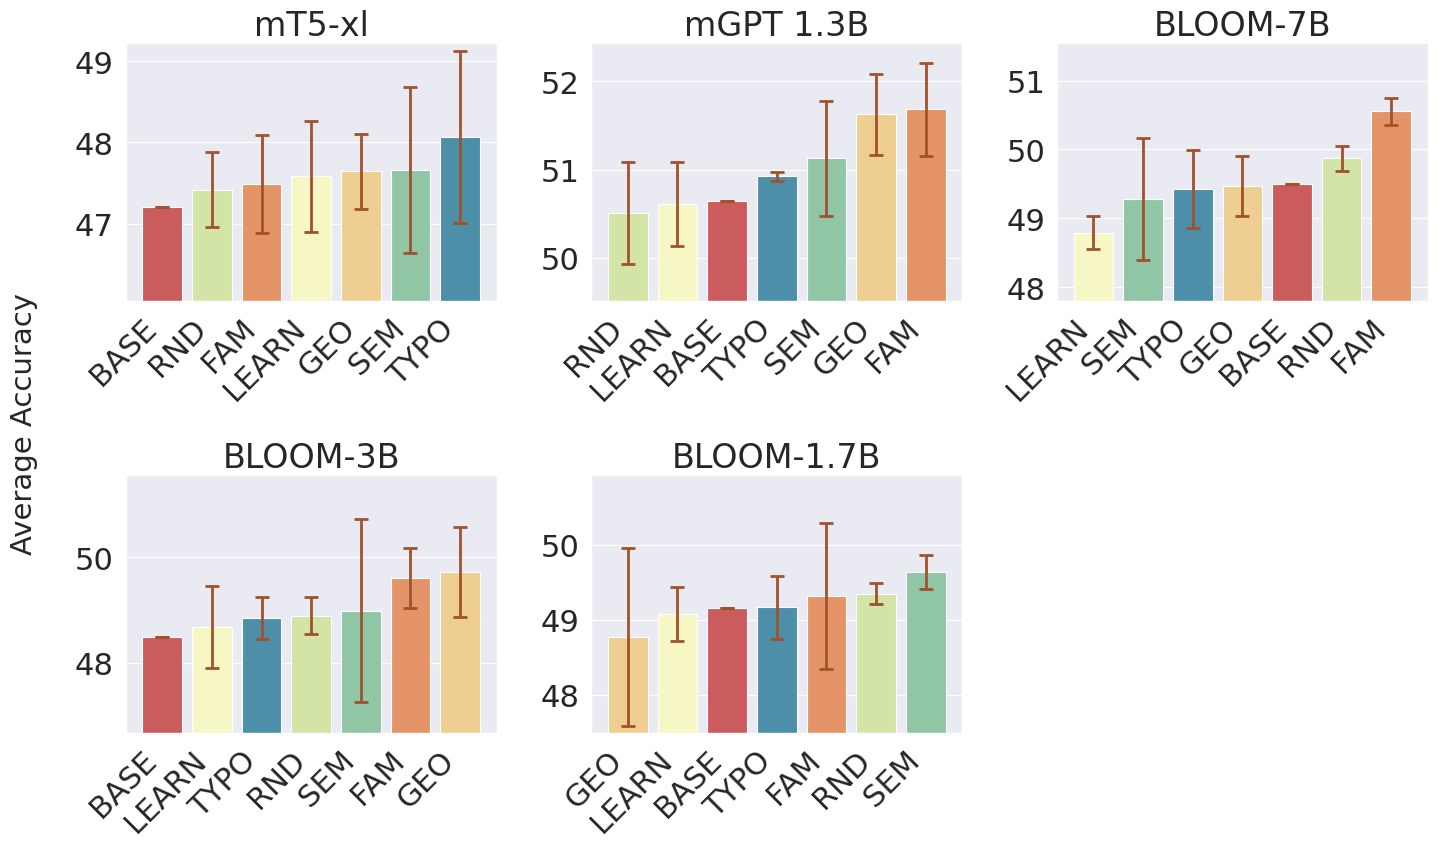

In [114]:
# Convert to DataFrame
df = pd.DataFrame(unseen_plot_data)

# Extract the model base name (e.g., mGPT, mT5-xl, BLOOM) for grouping
df['Model Base'] = df['Model Configuration'].apply(lambda x: x.split(' - ')[0].strip())

sns.set_context("paper", font_scale=2.5)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the number of rows and columns as needed

# Flatten the array of axes for easy iteration
axes = axes.flatten()

# Iterate over each unique model base and create a separate subplot for each
for i, model_base in enumerate(sorted(df['Model Base'].unique(), reverse=True)):
    # Filter the DataFrame for the current model base
    model_data = df[df['Model Base'] == model_base]

    model_data.sort_values(['Model Base', 'Average Score'], ascending=[True, True], inplace=True)

    model_data['Model Configuration'] = model_data['Model Configuration'].apply(lambda x: x.split(' - ')[-1])

    # Define a custom color palette for configuration types
    config_types = model_data['Model Configuration'].unique()
    config_types.sort()
    colors = sns.color_palette("Spectral", len(config_types))
    config_color_map = {config_type: color for config_type, color in zip(config_types, colors)}

    # Select the i-th subplot
    ax = axes[i]

    # Create the bar plot for the current model base
    # sns.barplot(x='Model Configuration', y='Average Score', data=model_data, ax=ax,
    #             palette=sns.color_palette("Spectral", ))

    # Create the bar plot for the current model base using the custom color map
    sns.barplot(x='Model Configuration', y='Average Score', data=model_data, ax=ax,
                palette=[config_color_map[config] for config in model_data['Model Configuration']])

    # ax.errorbar(data=model_data, x='Model Configuration', y='Average Score', yerr='Margin of Error', ls='', lw=1,
    #             color='black')

    ax.errorbar(
        data=model_data, x='Model Configuration', y='Average Score', yerr='Margin of Error',
        fmt='none',  # This removes any connecting lines between the error bars
        elinewidth=2,  # Controls the width of the error bars
        ecolor='sienna',
        capsize=5,  # Adds caps to the error bars
        capthick=2  # Controls the thickness of the error bar caps
    )

    # Set the title for the subplot
    ax.set_title(model_base)

    # Rotate x-tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Set a uniform y-axis range if needed
    ax.set_ylim(model_data['Average Score'].min() - max(max(model_data['Margin of Error']) + 0.1, 1),
                model_data['Average Score'].max() + max(max(model_data['Margin of Error']) + 0.1,
                                                        0.5))  # Update these values based on your data range

    # Hide x-axis labels for all but the bottom plots
    # if i < len(df['Model Base'].unique()) - 3:  # Adjust this index based on the number of columns
    ax.set_xlabel('')
    ax.set_ylabel('')
    # else:
    #     ax.set_xlabel('Model Configuration')

    # Hide y-axis labels for all but the leftmost plots
    if i % 3 != 0:  # Adjust this modulus based on the number of columns
        ax.set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.text(0.04, 0.5, 'Average Accuracy', ha='center', va='center', rotation='vertical', fontsize=21)

# Adjust the layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Save the figure
plt.savefig('add_not_seen_model_performance.png', dpi=300)

# Show the plot
plt.show()

# VIETNAMESE CASE

In [27]:
# Convert to DataFrame
df = flatten_data(results, filter_non_overall=True, calculate_unseen_overalls=False, vietnamese_mode=True)
df.to_csv('add_exp_results.csv')
# Calculate statistics
stats_df = calculate_stats(df)
stats_df.to_csv('add_exp_stats_results.csv')

# Display results
print(len(stats_df))

appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode xcopa
appended vietnamese mode xnli
appended vietnamese mode

In [21]:
df

,Model,Domain,Result Set,Task,Score
0,bloom3b,learned,3,pawsx,48.47
1,bloom3b,learned,3,xcopa,56.65
2,bloom3b,learned,3,xnli,40.47
3,bloom3b,learned,3,xstorycloze,59.67
4,bloom3b,learned,3,xwinograd,71.16
...,...,...,...,...,...
863,bloom7b,learned,3,xnli,41.45
864,bloom7b,learned,3,xstorycloze,61.78
865,bloom7b,learned,3,xwinograd,73.93
866,bloom7b,learned,3,SET AVG,56.44


In [20]:
vi_plot_data = {}
model_configs = []
avg_scores = []
error_margins = []

for item in stats_df.iterrows():
    task = item[0][2]
    model = item[0][0]
    lang_subset = item[0][1]

    if task != 'VI AVG':
        continue

    # temporarily disabled
    if lang_subset in ['resource']:
        continue


    def convert_to_model_alias(model_name):
        if model_name == 'mgpt':
            return "mGPT 1.3B"
        elif model_name == 'bloom1_7b':
            return "BLOOM-1.7B"
        elif model_name == 'bloom3b':
            return "BLOOM-3B"
        elif model_name == 'bloom7b':
            return "BLOOM-7B"
        elif model_name == 'mt5':
            return "mT5-xl"


    def convert_to_subset_alias(subset_name):
        if subset_name == "geo":
            return 'GEO'
        elif subset_name == "learned":
            return 'LEARN'
        elif subset_name == "random":
            return 'RND'
        elif subset_name == "resource":
            return 'RES'
        elif subset_name == 'semantic':
            return 'SEM'
        elif subset_name == 'typology':
            return 'TYPO'
        elif subset_name == 'vi':
            return 'VI'
        elif subset_name == 'family':
            return 'FAM'


    model_alias = convert_to_model_alias(model)
    subset_alias = convert_to_subset_alias(lang_subset)

    mean_res = item[1]['Mean']
    error_margin = item[1]['Margin_of_Error']
    avg_scores.append(mean_res)
    error_margins.append(error_margin)
    model_configs.append(f'{model_alias} - {subset_alias}')

vi_plot_data = {'Model Configuration': model_configs, 'Average Score': avg_scores, 'Margin of Error': error_margins}

pprint(vi_plot_data)

{'Average Score': [56.623333333333335,
                   55.22,
                   56.27666666666667,
                   55.903333333333336,
                   56.050000000000004,
                   55.88333333333333,
                   55.48500000000001,
                   57.339999999999996,
                   56.76666666666666,
                   57.52,
                   58.10333333333333,
                   56.958333333333336,
                   57.583333333333336,
                   56.571666666666665,
                   58.38500000000001,
                   58.656666666666666,
                   58.32166666666666,
                   58.56333333333333,
                   58.64166666666666,
                   58.98166666666666,
                   58.01833333333334,
                   52.836666666666666,
                   53.836666666666666,
                   53.25666666666666,
                   52.973333333333336,
                   52.35833333333333,
                   52.69,

/tmp/ipykernel_6967/879841201.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.sort_values(['Model Base', 'Average Score'], ascending=[True, True], inplace=True)
/tmp/ipykernel_6967/879841201.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['Model Configuration'] = model_data['Model Configuration'].apply(lambda x: x.split(' - ')[-1])
/tmp/ipykernel_6967/879841201.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for t

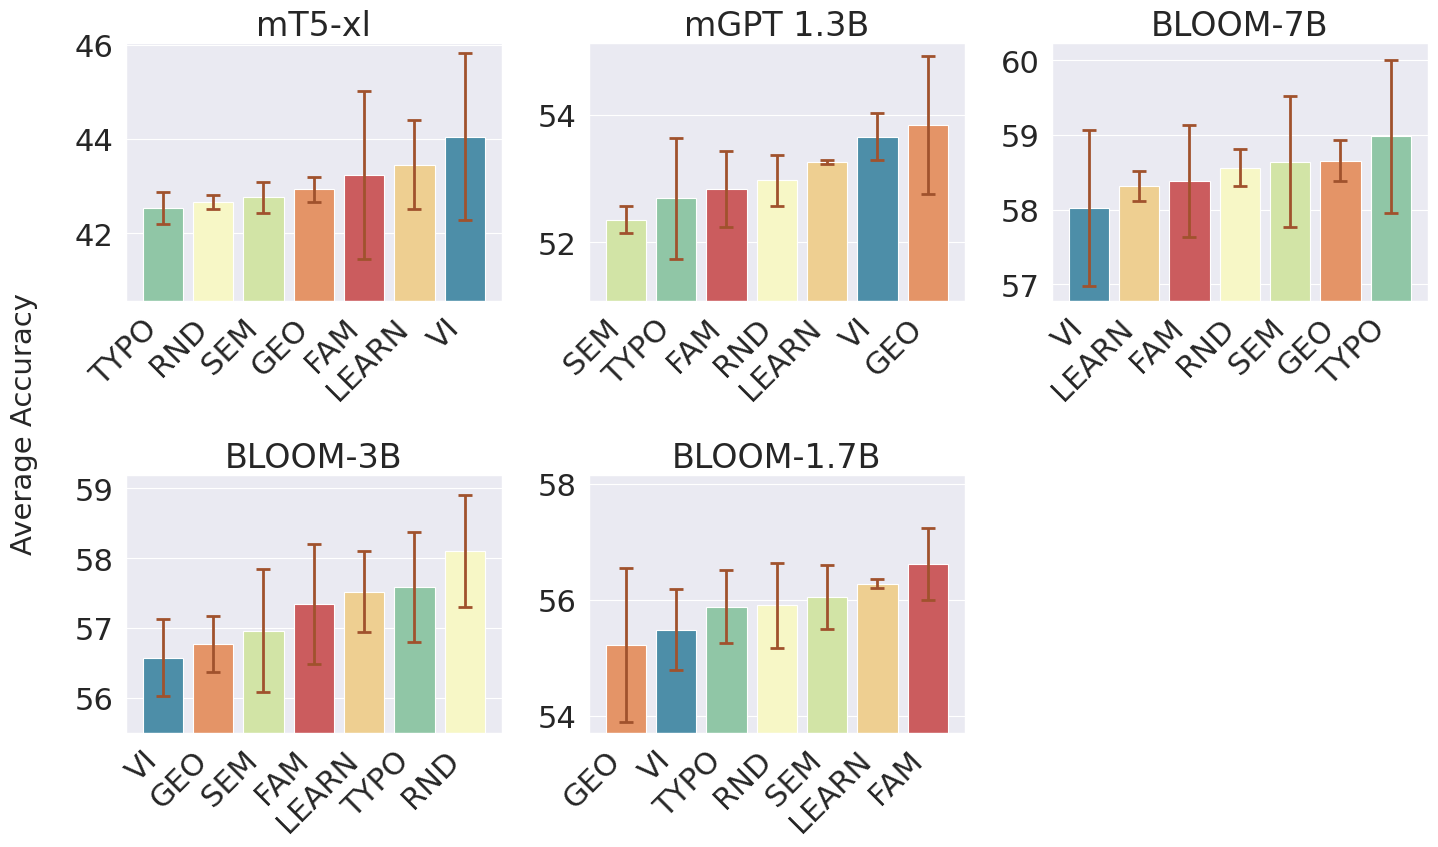

In [113]:
# Convert to DataFrame
df = pd.DataFrame(vi_plot_data)

# Extract the model base name (e.g., mGPT, mT5-xl, BLOOM) for grouping
df['Model Base'] = df['Model Configuration'].apply(lambda x: x.split(' - ')[0].strip())

sns.set_context("paper", font_scale=2.5)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the number of rows and columns as needed

# Flatten the array of axes for easy iteration
axes = axes.flatten()

# Iterate over each unique model base and create a separate subplot for each
for i, model_base in enumerate(sorted(df['Model Base'].unique(), reverse=True)):
    # Filter the DataFrame for the current model base
    model_data = df[df['Model Base'] == model_base]

    model_data.sort_values(['Model Base', 'Average Score'], ascending=[True, True], inplace=True)

    model_data['Model Configuration'] = model_data['Model Configuration'].apply(lambda x: x.split(' - ')[-1])

    # Define a custom color palette for configuration types
    config_types = model_data['Model Configuration'].unique()
    config_types.sort()
    colors = sns.color_palette("Spectral", len(config_types))
    config_color_map = {config_type: color for config_type, color in zip(config_types, colors)}

    # Select the i-th subplot
    ax = axes[i]

    # Create the bar plot for the current model base
    # sns.barplot(x='Model Configuration', y='Average Score', data=model_data, ax=ax,
    #             palette=sns.color_palette("Spectral", ))

    # Create the bar plot for the current model base using the custom color map
    sns.barplot(x='Model Configuration', y='Average Score', data=model_data, ax=ax,
                palette=[config_color_map[config] for config in model_data['Model Configuration']])

    # ax.errorbar(data=model_data, x='Model Configuration', y='Average Score', yerr='Margin of Error', ls='', lw=1,
    #             color='black')

    ax.errorbar(
        data=model_data, x='Model Configuration', y='Average Score', yerr='Margin of Error',
        fmt='none',  # This removes any connecting lines between the error bars
        elinewidth=2,  # Controls the width of the error bars
        ecolor='sienna',
        capsize=5,  # Adds caps to the error bars
        capthick=2  # Controls the thickness of the error bar caps
    )

    # Set the title for the subplot
    ax.set_title(model_base)

    # Rotate x-tick labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Set a uniform y-axis range if needed
    ax.set_ylim(model_data['Average Score'].min() - max(max(model_data['Margin of Error']) + 0.2, 1),
                model_data['Average Score'].max() + max(max(model_data['Margin of Error']) + 0.2,
                                                        0.5))  # Update these values based on your data range

    # Hide x-axis labels for all but the bottom plots
    # if i < len(df['Model Base'].unique()) - 3:  # Adjust this index based on the number of columns
    ax.set_xlabel('')
    ax.set_ylabel('')
    # else:
    #     ax.set_xlabel('Model Configuration')

    # Hide y-axis labels for all but the leftmost plots
    if i % 3 != 0:  # Adjust this modulus based on the number of columns
        ax.set_ylabel('')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.text(0.04, 0.5, 'Average Accuracy', ha='center', va='center', rotation='vertical', fontsize=21)

# Adjust the layout
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Save the figure
plt.savefig('add_vi_model_performance.png', dpi=300)

# Show the plot
plt.show()

# SCALING EFFECT

In [122]:
scaling_plot_data = {}
model_sizes = []
model_types = []
avg_scores = []
error_margins = []

for item in stats_df.iterrows():
    task = item[0][2]
    model = item[0][0]
    lang_subset = item[0][1]

    if task != 'SET AVG':
        continue

    # temporarily disabled
    if lang_subset in ['resource', 'vi']:
        continue

    if model in ['mgpt', 'mt5']:
        continue


    def convert_to_model_size(model_name):
        if model_name == 'bloom1_7b':
            return 1.7
        elif model_name == 'bloom3b':
            return 3
        elif model_name == 'bloom7b':
            return 7.1


    def convert_to_subset_alias(subset_name):
        if subset_name == "geo":
            return 'GEO'
        elif subset_name == "learned":
            return 'LEARN'
        elif subset_name == "random":
            return 'RND'
        elif subset_name == 'semantic':
            return 'SEM'
        elif subset_name == 'typology':
            return 'TYPO'
        elif subset_name == 'family':
            return 'FAM'


    model_size = convert_to_model_size(model)
    subset_alias = convert_to_subset_alias(lang_subset)

    mean_res = item[1]['Mean']
    error_margin = item[1]['Margin_of_Error']
    avg_scores.append(mean_res)
    error_margins.append(error_margin)
    model_sizes.append(model_size)
    model_types.append(subset_alias)

model_sizes.extend([1.7,
                    3,
                    7.1, ])
model_types.extend(['BASE',
                    'BASE',
                    'BASE', ])

avg_scores.extend([
    100 * 0.54238,
    100 * 0.54926,
    100 * 0.56126
])

error_margins.extend([0, 0, 0])

scaling_plot_data = {'Model Size': model_sizes, 'Model Type': model_types, 'Performance': avg_scores,
                     'Margin of Error': error_margins}

pprint(scaling_plot_data)

{'Margin of Error': [0.33795230535143517,
                     0.3715371013427919,
                     0.20329496626318105,
                     0.24147726737657904,
                     0.20658708145824412,
                     0.015178332134958596,
                     0.28958412071325446,
                     0.24693545070260906,
                     0.29811032586684705,
                     0.21843467995100077,
                     0.055989620529813225,
                     0.2743519896969412,
                     0.20868728224224561,
                     0.22952858911981808,
                     0.23239636051395546,
                     0.25372277759021483,
                     0.057583433833874854,
                     0.08168747336859475,
                     0,
                     0,
                     0],
 'Model Size': [1.7,
                1.7,
                1.7,
                1.7,
                1.7,
                1.7,
                3,
                3,
      

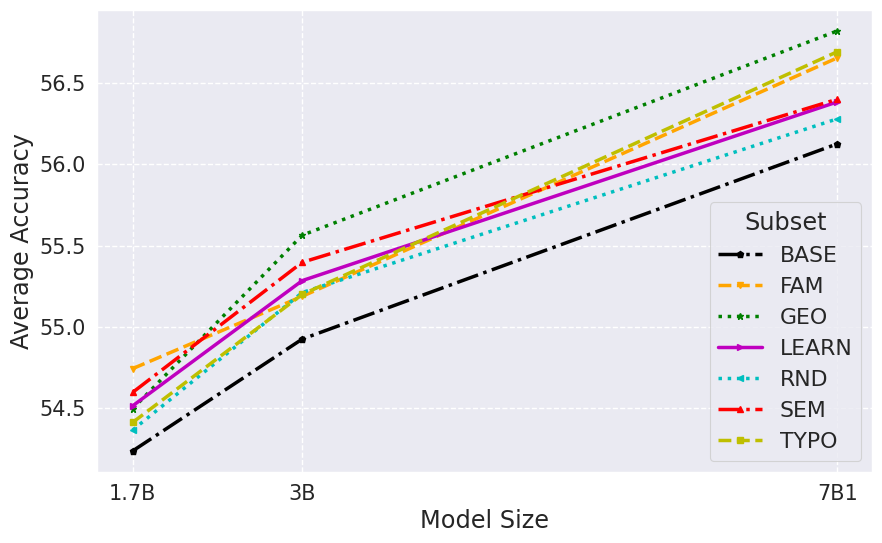

In [140]:
import matplotlib.pyplot as plt
import pandas as pd

# Data provided by you, rearranged into a dictionary
data = scaling_plot_data

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame to have model sizes as the index and types as columns
df_pivot = df.pivot(index='Model Size', columns='Model Type', values='Performance').reindex(
    [1.7, 3, 7.1])

lw = 2.5

# Define line styles and markers for each model type
line_styles = {
    'FAM': {'linestyle': '--', 'marker': 'v', 'color': 'orange', 'linewidth': lw},
    'SEM': {'linestyle': '-.', 'marker': '^', 'color': 'r', 'linewidth': lw},
    'RND': {'linestyle': ':', 'marker': '<', 'color': 'c', 'linewidth': lw},
    'LEARN': {'linestyle': '-', 'marker': '>', 'color': 'm', 'linewidth': lw},
    'TYPO': {'linestyle': '--', 'marker': 's', 'color': 'y', 'linewidth': lw},
    'BASE': {'linestyle': '-.', 'marker': 'p', 'color': 'k', 'linewidth': lw},
    'GEO': {'linestyle': ':', 'marker': '*', 'color': 'g', 'linewidth': lw},
}

sns.set_context("paper", font_scale=1.8)

# Plot each model type with a unique line style and marker
plt.figure(figsize=(10, 6))
for model_type in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[model_type], label=model_type,
             **line_styles.get(model_type, {'linestyle': '-', 'marker': 'o'}))

    # print('--------', df_pivot[model_type], df_pivot)
    # Model Size
    errors = []
    for size in [1.7, 3, 7.1]:
        err = df[(df['Model Type'] == model_type) & (df['Model Size'] == 1.7)].iloc[0]['Margin of Error']
        errors.append(err)

    # this does not look good
    # plt.fill_between(df_pivot.index,
    #                  df_pivot[model_type] - errors,
    #                  df_pivot[model_type] + errors,
    #                  color=line_styles[model_type]['color'],
    #                  alpha=0.05) 

# Add legend, titles and labels
plt.legend(title='Subset', loc='best')
plt.xlabel('Model Size')
plt.ylabel('Average Accuracy')
# plt.title('Scaling Effect of Model Size on Performance')

plt.tick_params(axis='both', which='major', labelsize=15)

# plt.xscale('log')
plt.xticks([1.7, 3, 7.1], ['1.7B', '3B', '7B1'])  # Set the ticks to the model sizes

# Customize the grid
plt.grid(True, which='both', linestyle='--', linewidth=1)

# Save the figure
plt.savefig('add_scaling_effect_large_font.png', dpi=300)

# Show the plot
plt.show()